This first section is a test on imports and have an image from our dataset populate.

In [1]:
#test
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

2024-12-08 13:25:24.296118: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 13:25:25.062775: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
category = 'culture' 
train_data = tf.data.Dataset.load(f'data/baby_train_{category}')
val_data = tf.data.Dataset.load(f'data/baby_valid_{category}')
train_data = train_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

2024-12-08 13:25:29.814070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.Distribu

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
2024-12-08 13:25:30.071479: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(200, 200, 3)


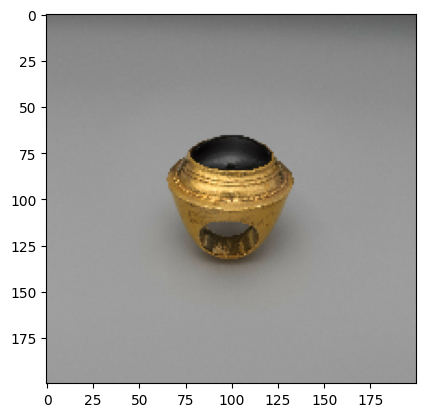

In [3]:
for image, label in train_data.take(1):
    plt.imshow(image)
    print(image.shape)#becky and I added this to make sure the shape is 200x200x3
    break

The pip installs below I needed as my enviornment stopped working, once running those it corrected the issue. 

In [4]:
#!pip install --user keras==2.15.0

In [5]:
#!pip install --user ml-dtypes==0.2.0

In [6]:
#!pip install --user tensorboard==2.15.0

In [7]:
#!pip install --user tensorflow-estimator==2.15.0

In [8]:
#!pip install --user tensorflow==2.15.0

In [4]:
#preliminary model

## Below is the final improved model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

#Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20

#data augmentation section
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

#Squeeze and Excitation Block, SE
def squeeze_excitation_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation Block."""
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    return layers.multiply([input_tensor, se])

#SENet Model with ResNet50 Backbone, as ResNet50 worked well for my model experimentation
def create_senet_model(input_shape=(224, 224, 3), num_classes=3):
    """Custom SENet model using a ResNet50 backbone."""
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet' 
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)  
    x = base_model(x, training=False)  

    
    x = squeeze_excitation_block(x)

    #pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes)(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

#Load datasets
print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

#SENet model
print("Creating SENet model...")
model = create_senet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

#compile model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

#training section
print("\nStarting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

#plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# #fine tuning the model 
# print("\nFine-tuning the base model...")
# base_model = model.layers[2]  
# base_model.trainable = True  


# for layer in base_model.layers[:100]:  
#     layer.trainable = False

# #recompile
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss=loss_fn,
#     metrics=["accuracy"]
# )

# #fine tune
# fine_tune_history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     verbose=1
# )

# #plotting
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(fine_tune_history.history["accuracy"], label="Fine-Tuning Training Accuracy")
# plt.plot(fine_tune_history.history["val_accuracy"], label="Fine-Tuning Validation Accuracy")
# plt.title("Fine-Tuning Model Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(fine_tune_history.history["loss"], label="Fine-Tuning Training Loss")
# plt.plot(fine_tune_history.history["val_loss"], label="Fine-Tuning Validation Loss")
# plt.title("Fine-Tuning Model Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()

import os

# Create directory and save model
# model_directory = "SDS/instructional/DS-6050-DL/24F/ClassicalArt_Project/submodels_final"
# os.makedirs(model_directory, exist_ok=True)
# model_path = os.path.join(model_directory, 'culture_model.keras')
# model.save(model_path)

#savesave
model_directory = "/sfs/gpfs/tardis/project/SDS/instructional/DS-6050-DL/24F/ClassicalArt_Project/submodels_final"
os.makedirs(model_directory, exist_ok=True)
model_path = os.path.join(model_directory, 'culture_model.keras')
model.save(model_path, save_format = 'keras')

#verification
print(f"Full path to model: {os.path.abspath(model_path)}")

2024-12-09 12:15:22.872541: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 12:15:23.348211: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:15:27.377542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43218 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:63:00.0, compute capability: 8.6
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.

Loading data...


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4117891810058567704


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating SENet model...


2024-12-09 12:15:28.133378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16311543332878446729
2024-12-09 12:15:28.313862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read th


Starting training...
Epoch 1/20


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 4117891810058567704
2024-12-09 12:15:32.078238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-12-09 12:15:32.622003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-09 12:15:33.174835: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ecefc1f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 12:15:33.174876: I tensorflow/compiler/xla/serv

96/96 [==============================] - ETA: 0s - loss: 1.3307 - accuracy: 0.3597

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 16311543332878446729


96/96 [==============================] - 10s 51ms/step - loss: 1.3307 - accuracy: 0.3597 - val_loss: 1.1689 - val_accuracy: 0.3196
Epoch 2/20
96/96 [==============================] - 4s 39ms/step - loss: 1.3056 - accuracy: 0.3551 - val_loss: 1.2264 - val_accuracy: 0.3196
Epoch 3/20
96/96 [==============================] - 4s 38ms/step - loss: 1.2641 - accuracy: 0.3557 - val_loss: 1.1217 - val_accuracy: 0.3402
Epoch 4/20
96/96 [==============================] - 4s 38ms/step - loss: 1.2785 - accuracy: 0.3476 - val_loss: 1.0793 - val_accuracy: 0.4604
Epoch 5/20
96/96 [==============================] - 4s 38ms/step - loss: 1.2424 - accuracy: 0.3717 - val_loss: 1.0765 - val_accuracy: 0.4721
Epoch 6/20
96/96 [==============================] - 4s 38ms/step - loss: 1.2434 - accuracy: 0.3590 - val_loss: 1.0713 - val_accuracy: 0.4663
Epoch 7/20
96/96 [==============================] - 4s 37ms/step - loss: 1.2538 - accuracy: 0.3541 - val_loss: 1.0721 - val_accuracy: 0.4663
Epoch 8/20
96/96 [=====

Full path to model: /sfs/gpfs/tardis/project/SDS/instructional/DS-6050-DL/24F/ClassicalArt_Project/submodels_final/culture_model.keras


In [2]:
#plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Culture Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

#load data
print("Loading data...")
category = 'culture'
train_data = tf.data.Dataset.load(f'data/baby_train_{category}')
val_data = tf.data.Dataset.load(f'data/baby_valid_{category}')

#hyperparameters
IMG_SIZE = 200
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 10

def encode_label(label):#decoding as it had issues passes images
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    #swap grayscale to rgb
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    
    #labeling
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    return image, label_idx

#now actually creating the datasets, shuffle etc as the codeathon1, and our tempalte
print("Creating datasets...")
def create_dataset(data):
    return (data
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_ds = create_dataset(train_data)
val_ds = create_dataset(val_data)

#modeling
print("Creating model...")
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))#had to pass imgsize here from the stored vaiable, instead of 200x200x3
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

#loss and optimizer function, stringed from previous hw here
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#this is where claude did explicit labels etc
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    train_acc_metric.update_state(labels, predictions)
    return loss

#val with claude
@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)


history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': []
}

print("\nStarting training...")
try:
    #training loop
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        #Training
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            
            if step % 10 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
        
        #calc acc
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        
        #val
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        
        #mets
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        
        #the reset metrics had to be swapped to state, like the issue we had with hw previously 
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
    
    #plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
#exception catch 
except Exception as e:
    print("\nError during training:", str(e))
    print("\nDiagnostic information:")
    for images, labels in train_ds.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Images dtype:", images.dtype)
        print("Labels dtype:", labels.dtype)
        print("Sample image values range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())
        print("Unique labels:", tf.unique(labels)[0].numpy())

#prediction function
@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    image = tf.expand_dims(image, 0)
    predictions = model(image, training=False)
    return tf.argmax(predictions[0])

Loading data...
Creating datasets...
Creating model...


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 556075849051947185



Starting training...

Epoch 1/10


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
2024-11-17 10:26:05.216457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-17 10:26:06.287167: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f01b2f1e030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 10:26:06.287195: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-11-17 10:26:06.408553: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.c

Step 0: Loss = 1.0986
Training accuracy: 0.3400


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 556075849051947185


Validation accuracy: 0.2000

Epoch 2/10
Step 0: Loss = 1.0531
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 3/10
Step 0: Loss = 1.0987
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 4/10
Step 0: Loss = 1.0453
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 5/10
Step 0: Loss = 1.0890
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 6/10
Step 0: Loss = 1.0951
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 7/10
Step 0: Loss = 1.0948
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 8/10
Step 0: Loss = 1.0867
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 9/10
Step 0: Loss = 1.0921
Training accuracy: 0.4600
Validation accuracy: 0.2000

Epoch 10/10
Step 0: Loss = 1.1041
Training accuracy: 0.4600
Validation accuracy: 0.2000


2024-11-18 16:02:24.246626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 16:02:24.246677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 16:02:24.247793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 16:02:24.254606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading data...


2024-11-18 16:02:30.241619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


Creating datasets...
Creating model...

Starting training...

Epoch 1/20


2024-11-18 16:02:33.189981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-18 16:02:34.185129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 16:02:40.434510: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fddbe3e9530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 16:02:40.434546: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 16:02:40.439795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731963760.542375  956781 device_compiler.h:186] Compiled cluster using XLA!  Thi

Step 0: Loss = 1.4782
Step 5: Loss = 1.4596
Step 10: Loss = 1.4139
Step 15: Loss = 1.5468
Step 20: Loss = 1.5950
Step 25: Loss = 1.3832
Step 30: Loss = 1.2456
Step 35: Loss = 1.2301
Step 40: Loss = 1.5442
Step 45: Loss = 1.6678
Step 50: Loss = 1.2748
Step 55: Loss = 1.2704
Step 60: Loss = 1.4245
Step 65: Loss = 1.1690
Step 70: Loss = 1.3652
Step 75: Loss = 1.6855
Step 80: Loss = 1.4974
Step 85: Loss = 1.3615
Step 90: Loss = 1.3407
Step 95: Loss = 1.4303
Training accuracy: 0.3417
Validation accuracy: 0.3196

Epoch 2/20
Step 0: Loss = 1.5759
Step 5: Loss = 1.5417
Step 10: Loss = 1.2480
Step 15: Loss = 1.5230
Step 20: Loss = 1.3619
Step 25: Loss = 1.6067
Step 30: Loss = 1.5650
Step 35: Loss = 1.4450
Step 40: Loss = 1.2681
Step 45: Loss = 1.2319
Step 50: Loss = 1.2507
Step 55: Loss = 1.3688
Step 60: Loss = 1.4353
Step 65: Loss = 1.2863
Step 70: Loss = 1.2537
Step 75: Loss = 1.3840
Step 80: Loss = 1.2230
Step 85: Loss = 1.1086
Step 90: Loss = 1.3547
Step 95: Loss = 1.2042
Training accuracy:

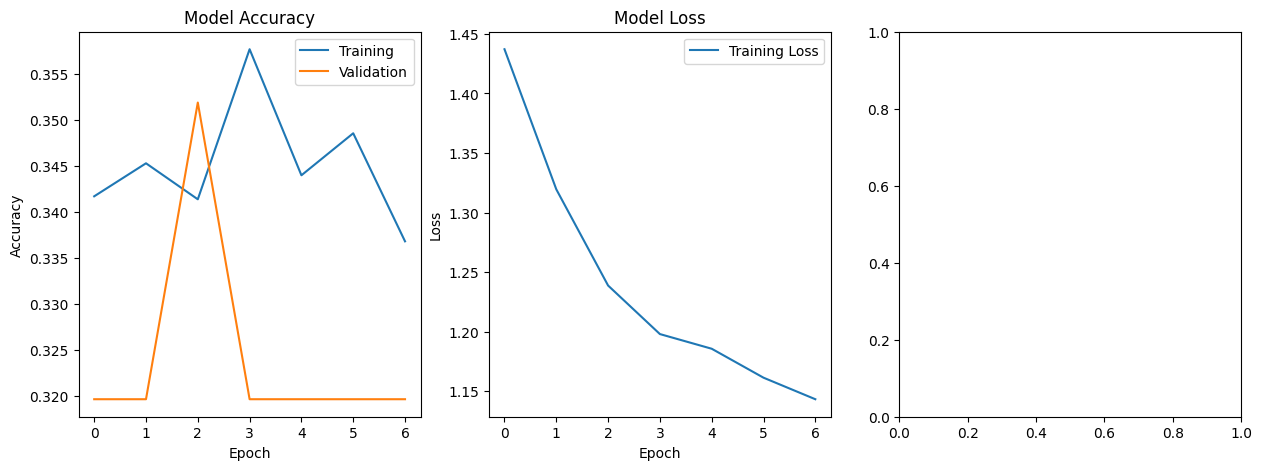

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

#load data
print("Loading data...")
category = 'culture'
train_data = tf.data.Dataset.load(f'data/train_{category}')
val_data = tf.data.Dataset.load(f'data/valid_{category}')

#hypterparameters
IMG_SIZE = 200
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20  # Increased epochs

#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    #image process
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    
    
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    return image, label_idx

#create datasets
print("Creating datasets...")
def create_dataset(data, is_training=False):
    ds = (data
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .shuffle(1000 if is_training else 100)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))
    return ds

train_ds = create_dataset(train_data, is_training=True)
val_ds = create_dataset(val_data)

#improved architecture
print("Creating model...")
def create_improved_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    
    x = data_augmentation(inputs)
    
    #1st
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    #2nd
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    #3rd
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    #dense layering
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = create_improved_model()

#LR
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

#loss and opti
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#training
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    
    gradients = tape.gradient(loss, model.trainable_weights)
    #gradients
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    train_acc_metric.update_state(labels, predictions)
    return loss

#val step
@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

#Training history
history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': []
}

#early stop
best_val_acc = 0
patience = 5
patience_counter = 0

print("\nStarting training...")
try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        #Training
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            
            if step % 5 == 0:  
                print(f"Step {step}: Loss = {float(loss):.4f}")
        
        #calc
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        
        #val
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        
        #early stop
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        #Store metrics
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        
        #resets
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
    
    #plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot([opt.numpy() for opt in optimizer.learning_rates], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    print("\nDiagnostic information:")
    for images, labels in train_ds.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Images dtype:", images.dtype)
        print("Labels dtype:", labels.dtype)
        print("Sample image values range:", tf.reduce_min(images).numpy(), 
              "to", tf.reduce_max(images).numpy())
        print("Unique labels:", tf.unique(labels)[0].numpy())

#prediction funct
@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    image = tf.expand_dims(image, 0)
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)

## Notes:
Here I worked with Becky to get the template code started and she helped me with the function to see the image and the shape. I initally tried to work off the codeathon 1 site example(https://www.tensorflow.org/tutorials/images/classification) this did help with the overall structure but I had many hours of shaping errors, resolved with becky while working through the data preprocessing notebook. I then referred to claude for the errors as they were very specific regarding shape and channels. Some images have 1 channel vs three, I think this is in relationship to premission constraints of the data preprocessing notebook and resolved by using the baby data while the master data was still processed. 
I noted in the code chunks the claude adds and left most of the claude notes. To note once we streamline this process with other creating models will help here. The second model did improve the validation accuracy. I think we should leave the catches in the code so that if there are shape issues again we will have an easier time to catch. 

Models:
Model 1 is using a CNN to classify the cultures of the image data. So in our case Egyptian, Greek, Roman. The model takes the pixel sizes as an input(200x200) then it processes them thorugh three convolutional block, each pass through the block is a Conv2d layer with ReLU activation, maxpooling2d to implement the feature extraction element. The model architecture is similar to the Codeathon 1 base model, the filter architecture starts with 32 filters then doubles to 64 filters. This is ther to act as a larger net to capture more complex features. The preprocess of the data accounts for RGB and grayscale images, so that way there is a catch for both as initally there was issue there. There is however, a custom loop for the training with the Adam optimizer, as this was the way to get runs to work. 

Model 2 is also a CNN to classifiy the images culture Egyptian, Greek, Roman. There are improvements in this model as it uses a doubled convolutional blocks, 64,128,256 filter. Also batch normalization was used here to help with the training step. The dropout rates were added and increased iteratively. There are more compelx training optimizations, learning rate decay, and gradient clipping to prevent gradient explosion, as discussed in class. GlobalAveragePooling 2d layer was added.

## The Below Model was just Testing

Loading data...
Creating datasets...
Creating model...


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 556075849051947185



Starting training...

Epoch 1/20


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897
2024-11-17 10:26:40.560043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Step 0: Loss = 1.6787


2024-11-17 10:26:42.655342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training accuracy: 0.2500


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 556075849051947185


Validation accuracy: 0.2000

Epoch 2/20
Step 0: Loss = 1.7782
Training accuracy: 0.3300
Validation accuracy: 0.5500

Epoch 3/20
Step 0: Loss = 1.8262
Training accuracy: 0.3300
Validation accuracy: 0.5500

Epoch 4/20
Step 0: Loss = 1.5765
Training accuracy: 0.3500
Validation accuracy: 0.5500

Epoch 5/20
Step 0: Loss = 1.2279
Training accuracy: 0.3700
Validation accuracy: 0.5500

Epoch 6/20
Step 0: Loss = 1.4508
Training accuracy: 0.2600
Validation accuracy: 0.5500

Epoch 7/20
Step 0: Loss = 1.6556
Training accuracy: 0.3500
Validation accuracy: 0.2000

Early stopping triggered after 7 epochs

Error during training: 'Adam' object has no attribute 'learning_rates'

Diagnostic information:
Images shape: (32, 200, 200, 3)
Labels shape: (32,)
Images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>
Sample image values range: 0.0 to 0.003921569
Unique labels: [1 0 2]


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13355455434727335897


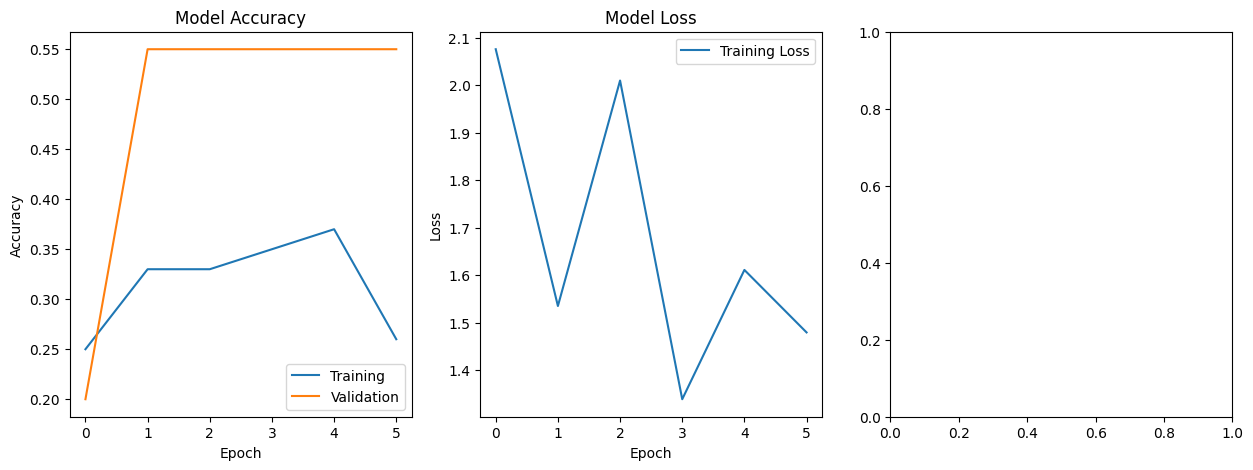

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

#load data
print("Loading data...")
category = 'culture'
train_data = tf.data.Dataset.load(f'data/baby_train_{category}')#we are using the baby data, SMALLER so be aware for trend in validation results
val_data = tf.data.Dataset.load(f'data/baby_valid_{category}')

#hypterparameters
IMG_SIZE = 200
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20  

#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    
    
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    return image, label_idx

#create datasets
print("Creating datasets...")
def create_dataset(data, is_training=False):
    ds = (data
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .shuffle(1000 if is_training else 100)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))
    return ds

train_ds = create_dataset(train_data, is_training=True)
val_ds = create_dataset(val_data)

#improved architecture
print("Creating model...")
def create_improved_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #train
    x = data_augmentation(inputs)
    
    #1st
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    #2nd
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    
    #3rd
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    #dense
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = create_improved_model()

#LR
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

#loss opti
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#gradient
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    
    gradients = tape.gradient(loss, model.trainable_weights)
    #gradients
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    train_acc_metric.update_state(labels, predictions)
    return loss

#val
@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

#train
history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': []
}

#early stop
best_val_acc = 0
patience = 5
patience_counter = 0

print("\nStarting training...")
try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        #train
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            
            if step % 5 == 0:  
                print(f"Step {step}: Loss = {float(loss):.4f}")
        
        #calc
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        
        #val
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        
        #early
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        #mets
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        
        #reset
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
    
    #plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot([opt.numpy() for opt in optimizer.learning_rates], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    print("\nDiagnostic information:")
    for images, labels in train_ds.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Images dtype:", images.dtype)
        print("Labels dtype:", labels.dtype)
        print("Sample image values range:", tf.reduce_min(images).numpy(), 
              "to", tf.reduce_max(images).numpy())
        print("Unique labels:", tf.unique(labels)[0].numpy())

#preds
@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    image = tf.expand_dims(image, 0)
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)

## Transfer Learning Section

## This model is using ResNet50

Loading data...
Sample data structure: <class 'tuple'>
Sample shapes: [<tf.Tensor: shape=(3,), dtype=int32, numpy=array([200, 200,   3], dtype=int32)>, <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>]
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:30:09.929407: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:30:10.307125: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:30:17.113768: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:30:20.466652: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efb65303070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:30:20.466686: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:30:20.474717: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731961820.579563  899019 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.6508
Step 5: Loss = 1.6031
Step 10: Loss = 1.3475
Step 15: Loss = 1.3764
Step 20: Loss = 1.4722
Step 25: Loss = 1.5090
Step 30: Loss = 1.4166
Step 35: Loss = 1.4604
Step 40: Loss = 1.4607
Step 45: Loss = 1.3224
Step 50: Loss = 1.6507
Step 55: Loss = 1.1373
Step 60: Loss = 1.3100
Step 65: Loss = 1.6520
Step 70: Loss = 1.5369
Step 75: Loss = 1.3124
Step 80: Loss = 1.4590
Step 85: Loss = 1.3923
Step 90: Loss = 1.3319
Step 95: Loss = 1.2654
Training accuracy: 0.3463
Validation accuracy: 0.3284

Epoch 2/20
Step 0: Loss = 1.5648
Step 5: Loss = 1.3814
Step 10: Loss = 1.2516
Step 15: Loss = 1.4986
Step 20: Loss = 1.5588
Step 25: Loss = 1.2210
Step 30: Loss = 1.0052
Step 35: Loss = 1.6549
Step 40: Loss = 1.3635
Step 45: Loss = 1.2539
Step 50: Loss = 1.3145
Step 55: Loss = 1.5086
Step 60: Loss = 1.5137
Step 65: Loss = 1.3470
Step 70: Loss = 1.1522
Step 75: Loss = 1.3504
Step 80: Loss = 1.4340
Step 85: Loss = 1.3947
Step 90: Loss = 1.2923
Step 95: Loss = 1.3051
Training accuracy:

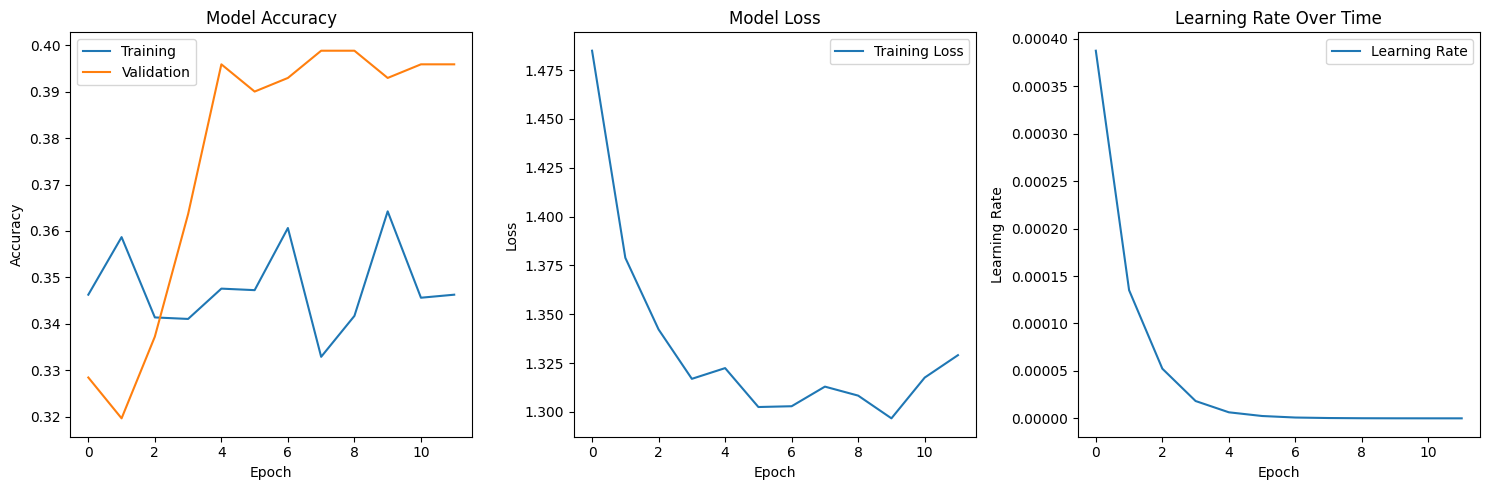

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


#Hyperparameters
IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20

#data aug
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    """Modified preprocessing function with explicit shape handling"""
    #images
    image = tf.ensure_shape(image, [None, None, None])
    
    image = tf.cast(image, tf.float32)
    
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    
    #resize
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    
    #label
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    
    return image, label_idx

def create_dataset(data, is_training=False):
    """Modified dataset creation with error handling"""
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        
        return ds
    
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        print("\nDiagnostic information:")
        for sample in data.take(1):
            if isinstance(sample, tuple):
                print("Sample structure:", [tf.shape(x) for x in sample])
            else:
                print("Sample structure:", tf.shape(sample))
        raise

def create_transfer_model():
    """Create model with transfer learning using ResNet50"""
    #pre trained resnet
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #train aug
    x = data_augmentation(inputs)
    
    x = tf.keras.applications.resnet50.preprocess_input(x)
    
    #base
    x = base_model(x, training=False)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

#load
print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    
    for sample in train_data.take(1):
        print("Sample data structure:", type(sample))
        if isinstance(sample, tuple):
            print("Sample shapes:", [tf.shape(x) for x in sample])
    
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

print("Creating model with transfer learning...")
model = create_transfer_model()

#LR
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)

#loss and opti
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]  
    base_model.trainable = True
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )


history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': [],
    'learning_rates': []
}


print("\nStarting training...")
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        #calc
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        
        #val
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        
        #LR
        current_lr = lr_schedule(step_counter)
        
        #early stop
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        #mets
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        
        #resets
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        
        #tuning
        if epoch == 10 and best_val_acc > 0.7:  
            unfreeze_model()
    
    #plotting
    plt.figure(figsize=(15, 5))
    
    
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    print("\nDiagnostic information:")
    for images, labels in train_ds.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Images dtype:", images.dtype)
        print("Labels dtype:", labels.dtype)
        print("Sample image values range:", tf.reduce_min(images).numpy(), 
              "to", tf.reduce_max(images).numpy())
        print("Unique labels:", tf.unique(labels)[0].numpy())
#preds
@tf.function
def predict(image):
    """Predict function with proper preprocessing"""
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.expand_dims(image, 0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)

## This Model uses EfficientNetV2B0

2024-11-18 15:33:17.489361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:33:17.489406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:33:17.490482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:33:17.497324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:33:26.903056: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:33:27.788611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:33:28.087231: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:33:37.377174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:33:39.922638: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f474d7c8520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:33:39.922674: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:33:39.928027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962020.029284  901986 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 2.1872
Step 5: Loss = 1.7496
Step 10: Loss = 1.2872
Step 15: Loss = 1.2599
Step 20: Loss = 1.5050
Step 25: Loss = 1.0501
Step 30: Loss = 1.4759
Step 35: Loss = 1.5566
Step 40: Loss = 1.3141
Step 45: Loss = 1.4872
Step 50: Loss = 1.6502
Step 55: Loss = 2.0033
Step 60: Loss = 1.5512
Step 65: Loss = 1.4273
Step 70: Loss = 1.3519
Step 75: Loss = 1.3777
Step 80: Loss = 1.3373
Step 85: Loss = 1.3010
Step 90: Loss = 1.2763
Step 95: Loss = 1.3743
Training accuracy: 0.3371
Validation accuracy: 0.3196

Epoch 2/20
Step 0: Loss = 1.1543
Step 5: Loss = 1.6392
Step 10: Loss = 1.3159
Step 15: Loss = 1.3298
Step 20: Loss = 1.1254
Step 25: Loss = 1.4826
Step 30: Loss = 1.7841
Step 35: Loss = 1.5979
Step 40: Loss = 1.5863
Step 45: Loss = 1.1531
Step 50: Loss = 1.4123
Step 55: Loss = 1.3334
Step 60: Loss = 1.4151
Step 65: Loss = 1.4764
Step 70: Loss = 1.3307
Step 75: Loss = 1.1925
Step 80: Loss = 1.2269
Step 85: Loss = 1.5259
Step 90: Loss = 1.0517
Step 95: Loss = 1.2456
Training accuracy:

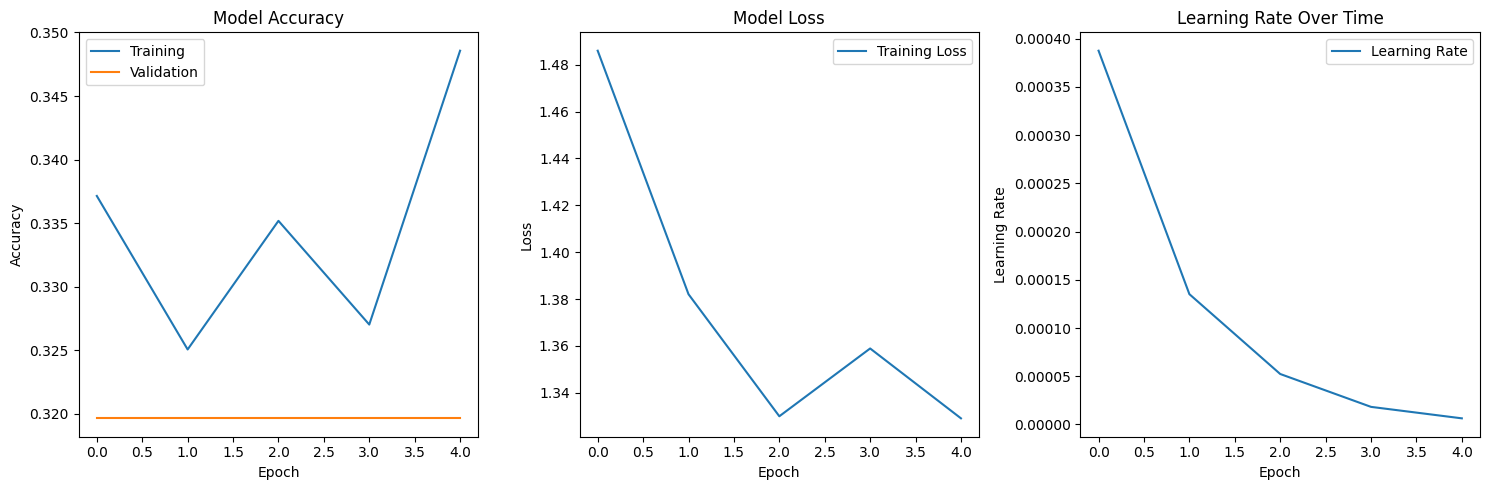

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0


IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    """Modified preprocessing function with explicit shape handling"""
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    """Modified dataset creation with error handling"""
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using EfficientNetV2B0"""
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

print("Creating model with transfer learning...")
model = create_transfer_model()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )

history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': [],
    'learning_rates': []
}

print("\nStarting training...")
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    raise

@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.expand_dims(image, 0)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)


## MobileNet Model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2


IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    """Preprocess function for image and label"""
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    """Create dataset with preprocessing and augmentation"""
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model using MobileNetV2 for transfer learning"""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

print("Creating model with transfer learning...")
model = create_transfer_model()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )

history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': [],
    'learning_rates': []
}

print("\nStarting training...")
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1

        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")

        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")

        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))

        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    raise

@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.expand_dims(image, 0)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)


2024-11-18 15:34:50.979900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:34:50.979946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:34:50.981014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:34:50.987836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:34:56.956769: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:34:57.711482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:34:57.944702: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:35:03.833513: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:35:05.803577: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0e1bccd6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:35:05.803611: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:35:05.808896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962105.909154  903665 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.6960
Step 5: Loss = 1.6999
Step 10: Loss = 1.4868
Step 15: Loss = 2.0730
Step 20: Loss = 1.5209
Step 25: Loss = 1.6287
Step 30: Loss = 1.7334
Step 35: Loss = 1.4587
Step 40: Loss = 1.8057
Step 45: Loss = 1.4549
Step 50: Loss = 1.2698
Step 55: Loss = 1.3272
Step 60: Loss = 1.3540
Step 65: Loss = 1.5653
Step 70: Loss = 1.2027
Step 75: Loss = 1.6308
Step 80: Loss = 1.2099
Step 85: Loss = 1.2905
Step 90: Loss = 1.2333
Step 95: Loss = 1.5075
Training accuracy: 0.3424
Validation accuracy: 0.3519

Epoch 2/20
Step 0: Loss = 1.2834
Step 5: Loss = 1.4004
Step 10: Loss = 1.1301
Step 15: Loss = 1.5243
Step 20: Loss = 1.4242
Step 25: Loss = 1.3569
Step 30: Loss = 1.5893
Step 35: Loss = 1.3353
Step 40: Loss = 1.3444
Step 45: Loss = 1.5515
Step 50: Loss = 1.3417
Step 55: Loss = 1.4708
Step 60: Loss = 1.2300
Step 65: Loss = 1.0236
Step 70: Loss = 1.3567
Step 75: Loss = 1.4518
Step 80: Loss = 1.3409
Step 85: Loss = 1.3945
Step 90: Loss = 1.6157
Step 95: Loss = 1.2643
Training accuracy:

## Inception V3

2024-11-18 15:35:55.776418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:35:55.776467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:35:55.777533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:35:55.784712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:36:01.489596: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 299, 299, 3), Labels shape: (32,)


2024-11-18 15:36:02.251661: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 299, 299, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:36:02.531942: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:36:10.463055: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:36:15.043405: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc6a92a550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:36:15.043442: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:36:15.049200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962175.147389  905557 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.6645
Step 5: Loss = 1.4057
Step 10: Loss = 1.3559
Step 15: Loss = 1.5387
Step 20: Loss = 1.5541
Step 25: Loss = 1.2960
Step 30: Loss = 1.3751
Step 35: Loss = 1.4506
Step 40: Loss = 1.2003
Step 45: Loss = 1.1732
Step 50: Loss = 1.2551
Step 55: Loss = 1.1892
Step 60: Loss = 1.1939
Step 65: Loss = 1.2973
Step 70: Loss = 1.2418
Step 75: Loss = 1.5090
Step 80: Loss = 1.2995
Step 85: Loss = 1.6327
Step 90: Loss = 1.6024
Step 95: Loss = 1.7603
Training accuracy: 0.3593
Validation accuracy: 0.3783

Epoch 2/20
Step 0: Loss = 1.3376
Step 5: Loss = 1.2089
Step 10: Loss = 1.2875
Step 15: Loss = 1.1070
Step 20: Loss = 1.2010
Step 25: Loss = 1.3174
Step 30: Loss = 1.2644
Step 35: Loss = 1.5668
Step 40: Loss = 1.2385
Step 45: Loss = 1.4323
Step 50: Loss = 1.4610
Step 55: Loss = 1.0684
Step 60: Loss = 1.6351
Step 65: Loss = 1.2329
Step 70: Loss = 1.5902
Step 75: Loss = 1.1280
Step 80: Loss = 1.4073
Step 85: Loss = 0.9269
Step 90: Loss = 1.2005
Step 95: Loss = 1.3087
Training accuracy:

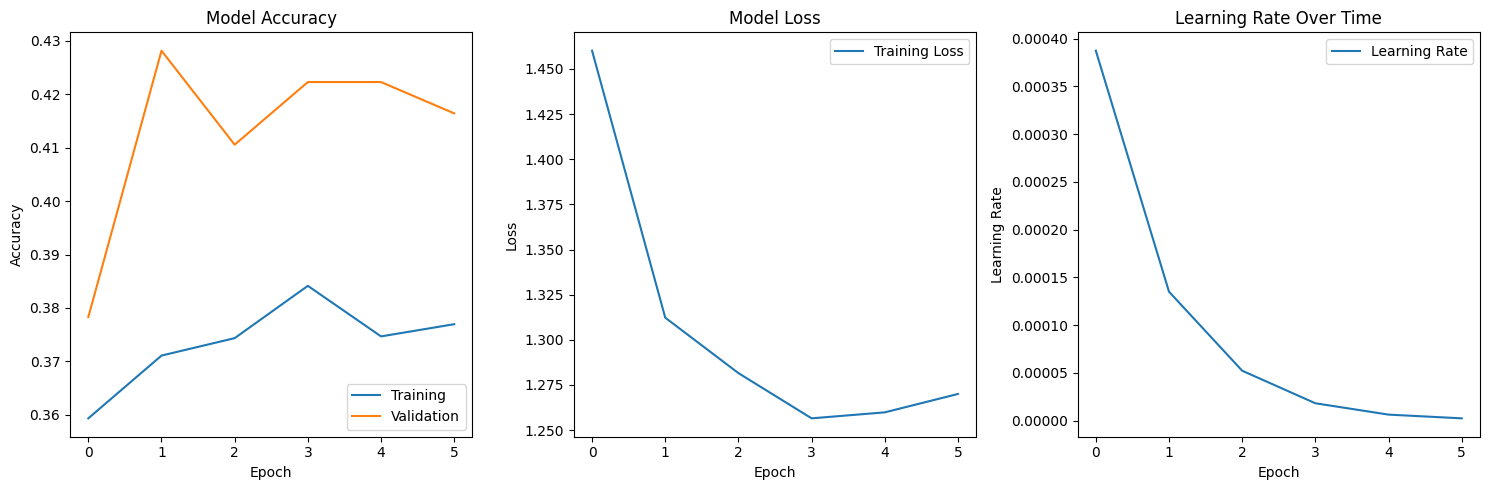

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import InceptionV3


IMG_SIZE = 299  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    """Preprocess function for image and label"""
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    """Create dataset with preprocessing and augmentation"""
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model using InceptionV3 for transfer learning"""
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

print("Creating model with transfer learning...")
model = create_transfer_model()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )

history = {
    'loss': [],
    'accuracy': [],
    'val_accuracy': [],
    'learning_rates': []
}

print("\nStarting training...")
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1

        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")

        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")

        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))

        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("\nError during training:", str(e))
    raise

@tf.function
def predict(image):
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.expand_dims(image, 0)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    predictions = model(image, training=False)
    probabilities = tf.nn.softmax(predictions[0])
    class_idx = tf.argmax(probabilities)
    confidence = tf.reduce_max(probabilities)
    return CLASSES[int(class_idx)], float(confidence)


## DenseNet

2024-11-18 15:37:13.772559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:37:13.772608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:37:13.773677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:37:13.780732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:37:19.843462: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:37:20.575446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:37:20.814333: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:37:30.684234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:37:33.442130: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd0c7241ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:37:33.442167: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:37:33.447402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962253.545507  907175 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 2.2873
Step 5: Loss = 1.6863
Step 10: Loss = 1.3176
Step 15: Loss = 1.3573
Step 20: Loss = 1.4288
Step 25: Loss = 1.7333
Step 30: Loss = 1.8337
Step 35: Loss = 1.4261
Step 40: Loss = 1.7079
Step 45: Loss = 1.2963
Step 50: Loss = 1.4203
Step 55: Loss = 1.5148
Step 60: Loss = 1.1827
Step 65: Loss = 1.1716
Step 70: Loss = 1.7597
Step 75: Loss = 1.4683
Step 80: Loss = 1.2396
Step 85: Loss = 1.3074
Step 90: Loss = 1.1895
Step 95: Loss = 1.4053
Training accuracy: 0.3659
Validation accuracy: 0.3460

Epoch 2/20
Step 0: Loss = 1.2285
Step 5: Loss = 1.1306
Step 10: Loss = 1.2137
Step 15: Loss = 1.4302
Step 20: Loss = 1.3596
Step 25: Loss = 1.3924
Step 30: Loss = 1.4289
Step 35: Loss = 1.6321
Step 40: Loss = 1.0797
Step 45: Loss = 1.3524
Step 50: Loss = 1.0360
Step 55: Loss = 1.2078
Step 60: Loss = 1.1699
Step 65: Loss = 1.1943
Step 70: Loss = 1.7537
Step 75: Loss = 1.3073
Step 80: Loss = 1.5414
Step 85: Loss = 1.4569
Step 90: Loss = 1.2204
Step 95: Loss = 1.2198
Training accuracy:

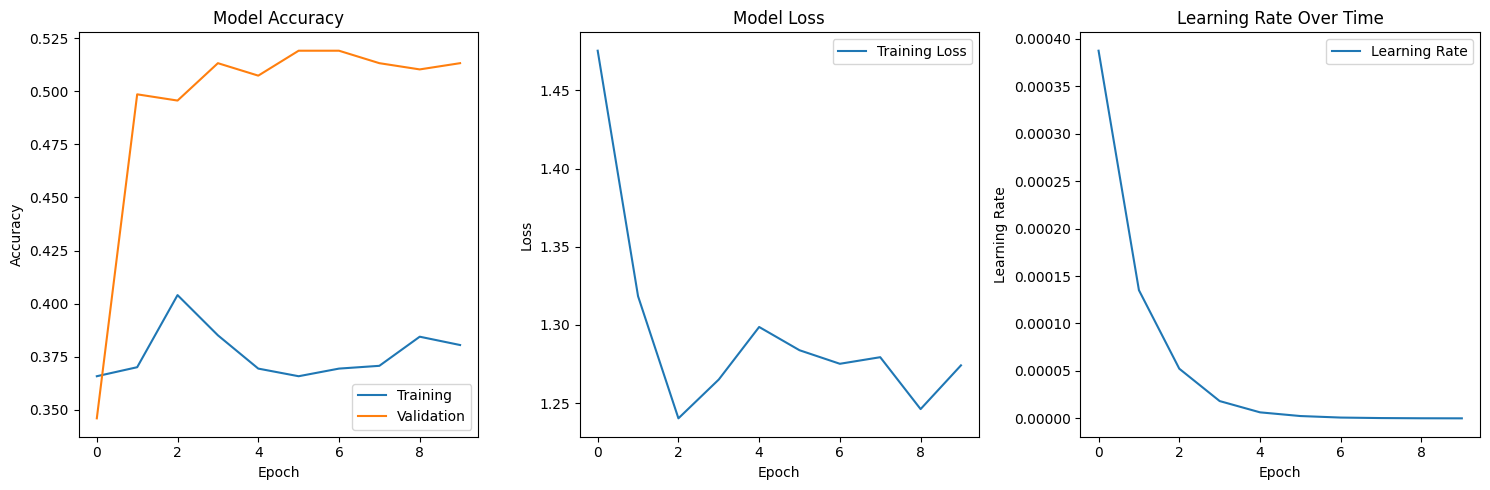

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using DenseNet121"""
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.densenet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


print("Creating model with transfer learning...")
model = create_transfer_model()


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )


print("\nStarting training...")
history = {'loss': [], 'accuracy': [], 'val_accuracy': [], 'learning_rates': []}
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nError during training:", str(e))


## NasNet

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using NASNetMobile"""
    base_model = tf.keras.applications.NASNetMobile(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.nasnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


print("Creating model with transfer learning...")
model = create_transfer_model()


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )


print("\nStarting training...")
history = {'loss': [], 'accuracy': [], 'val_accuracy': [], 'learning_rates': []}
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nError during training:", str(e))


2024-11-18 15:38:45.717451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:38:45.717503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:38:45.718584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:38:45.725706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:38:51.194344: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:38:51.947604: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:38:52.199233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:39:08.445670: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:39:10.508050: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1be4169bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:39:10.508086: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:39:10.513583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962350.613012  909010 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.6644
Step 5: Loss = 1.9382
Step 10: Loss = 1.3844
Step 15: Loss = 1.8662
Step 20: Loss = 1.3695
Step 25: Loss = 1.4991
Step 30: Loss = 1.7401
Step 35: Loss = 1.6855
Step 40: Loss = 1.5126
Step 45: Loss = 1.6635
Step 50: Loss = 1.4796
Step 55: Loss = 1.2092
Step 60: Loss = 1.3348
Step 65: Loss = 1.5066
Step 70: Loss = 1.5687
Step 75: Loss = 1.6529
Step 80: Loss = 1.2599
Step 85: Loss = 1.3839
Step 90: Loss = 1.1592
Step 95: Loss = 1.4316
Training accuracy: 0.3538
Validation accuracy: 0.3519

Epoch 2/20
Step 0: Loss = 1.5121
Step 5: Loss = 1.5182
Step 10: Loss = 1.3252
Step 15: Loss = 1.7348
Step 20: Loss = 1.3822
Step 25: Loss = 1.3005
Step 30: Loss = 1.3979
Step 35: Loss = 1.1755
Step 40: Loss = 1.2989
Step 45: Loss = 1.3200
Step 50: Loss = 1.5225
Step 55: Loss = 1.0590
Step 60: Loss = 1.5666
Step 65: Loss = 1.3275
Step 70: Loss = 1.3938
Step 75: Loss = 1.2285
Step 80: Loss = 1.2229
Step 85: Loss = 1.3522
Step 90: Loss = 1.2009
Step 95: Loss = 1.2616
Training accuracy:

## ResNet101

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using ResNet101"""
    base_model = tf.keras.applications.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


print("Creating model with transfer learning...")
model = create_transfer_model()


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )


print("\nStarting training...")
history = {'loss': [], 'accuracy': [], 'val_accuracy': [], 'learning_rates': []}
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nError during training:", str(e))


2024-11-18 15:40:41.524403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:40:41.524454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:40:41.525526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:40:41.532483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:40:47.637774: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:40:48.486981: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:40:48.719685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:40:58.330540: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:41:01.238787: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f22587b2230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:41:01.238825: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:41:01.244490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962461.346011  911638 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.3918
Step 5: Loss = 1.9356
Step 10: Loss = 1.8737
Step 15: Loss = 1.7543
Step 20: Loss = 1.5697
Step 25: Loss = 1.4997
Step 30: Loss = 1.9331
Step 35: Loss = 1.3465
Step 40: Loss = 1.5553
Step 45: Loss = 1.4071
Step 50: Loss = 1.5692
Step 55: Loss = 1.5779
Step 60: Loss = 1.1737
Step 65: Loss = 1.3481
Step 70: Loss = 1.2749
Step 75: Loss = 1.4297
Step 80: Loss = 1.6669
Step 85: Loss = 1.3654
Step 90: Loss = 1.5480
Step 95: Loss = 1.5305
Training accuracy: 0.3443
Validation accuracy: 0.3196

Epoch 2/20
Step 0: Loss = 1.3029
Step 5: Loss = 1.3464
Step 10: Loss = 1.3041
Step 15: Loss = 1.3673
Step 20: Loss = 1.4771
Step 25: Loss = 1.2867
Step 30: Loss = 1.2868
Step 35: Loss = 1.4884
Step 40: Loss = 1.2323
Step 45: Loss = 1.2801
Step 50: Loss = 1.6724
Step 55: Loss = 1.4550
Step 60: Loss = 1.2239
Step 65: Loss = 1.2226
Step 70: Loss = 1.1988
Step 75: Loss = 1.5513
Step 80: Loss = 1.4203
Step 85: Loss = 1.3371
Step 90: Loss = 1.5332
Step 95: Loss = 1.5037
Training accuracy:

## ResNet152

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using ResNet152"""
    base_model = tf.keras.applications.ResNet152(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise


print("Creating model with transfer learning...")
model = create_transfer_model()


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )


print("\nStarting training...")
history = {'loss': [], 'accuracy': [], 'val_accuracy': [], 'learning_rates': []}
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nError during training:", str(e))


2024-11-18 15:42:41.823878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:42:41.823928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:42:41.825003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:42:41.831800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:42:47.784332: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:42:48.676454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:42:48.922414: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:43:01.563568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:43:04.510603: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef087f787e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:43:04.510640: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-18 15:43:04.516157: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731962584.625502  913634 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step 0: Loss = 1.5011
Step 5: Loss = 1.6744
Step 10: Loss = 1.7149
Step 15: Loss = 1.6787
Step 20: Loss = 1.4344
Step 25: Loss = 1.5725
Step 30: Loss = 1.6123
Step 35: Loss = 1.5462
Step 40: Loss = 1.4115
Step 45: Loss = 1.3438
Step 50: Loss = 1.5723
Step 55: Loss = 1.7135
Step 60: Loss = 1.3594
Step 65: Loss = 1.2078
Step 70: Loss = 1.5282
Step 75: Loss = 1.5716
Step 80: Loss = 1.8920
Step 85: Loss = 1.4397
Step 90: Loss = 1.4970
Step 95: Loss = 1.4265
Training accuracy: 0.3355
Validation accuracy: 0.3167

Epoch 2/20
Step 0: Loss = 1.4297
Step 5: Loss = 1.0978
Step 10: Loss = 1.3085
Step 15: Loss = 1.3914
Step 20: Loss = 1.3346
Step 25: Loss = 1.4950
Step 30: Loss = 1.0668
Step 35: Loss = 1.2067
Step 40: Loss = 1.5092
Step 45: Loss = 1.2510
Step 50: Loss = 1.2530
Step 55: Loss = 1.4839
Step 60: Loss = 1.4271
Step 65: Loss = 1.3127
Step 70: Loss = 1.3985
Step 75: Loss = 1.3336
Step 80: Loss = 1.5046
Step 85: Loss = 1.3059
Step 90: Loss = 1.3012
Step 95: Loss = 1.4159
Training accuracy:

## ConvNeXt

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
IMG_SIZE = 224  # ConvNeXt default size
BATCH_SIZE = 32
NUM_CLASSES = 3
CLASSES = ['Egyptian', 'Greek', 'Roman']
EPOCHS = 20

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.2, 0.2),
])

def encode_label(label):
    label_str = label.numpy().decode('utf-8')
    return CLASSES.index(label_str)

def preprocess(image, label):
    image = tf.ensure_shape(image, [None, None, None])
    image = tf.cast(image, tf.float32)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    label_idx = tf.py_function(func=encode_label, inp=[label], Tout=tf.int32)
    label_idx = tf.reshape(label_idx, ())
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_idx.set_shape(())
    return image, label_idx

def create_dataset(data, is_training=False):
    try:
        ds = (data
              .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()
              .shuffle(1000 if is_training else 100)
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))
        for images, labels in ds.take(1):
            print(f"Dataset verification - Images shape: {images.shape}, Labels shape: {labels.shape}")
        return ds
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        raise

def create_transfer_model():
    """Create model with transfer learning using ConvNeXt"""
    base_model = tf.keras.applications.ConvNeXtBase(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.convnext.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Load and prepare datasets
print("Loading data...")
try:
    category = 'culture'
    train_data = tf.data.Dataset.load(f'data/train_{category}')
    val_data = tf.data.Dataset.load(f'data/valid_{category}')
    train_ds = create_dataset(train_data, is_training=True)
    val_ds = create_dataset(val_data)
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Create model
print("Creating model with transfer learning...")
model = create_transfer_model()

# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True
)

# Loss and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(labels, predictions)
    return loss

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    val_acc_metric.update_state(labels, predictions)

def unfreeze_model():
    """Unfreeze layers for fine-tuning"""
    print("Fine-tuning model...")
    base_model = model.layers[3]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=loss_fn,
        metrics=['accuracy']
    )

# Training loop
print("\nStarting training...")
history = {'loss': [], 'accuracy': [], 'val_accuracy': [], 'learning_rates': []}
try:
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    step_counter = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        epoch_loss = []
        for step, (images, labels) in enumerate(train_ds):
            loss = train_step(images, labels)
            epoch_loss.append(float(loss))
            if step % 5 == 0:
                print(f"Step {step}: Loss = {float(loss):.4f}")
            step_counter += 1
        
        train_acc = train_acc_metric.result()
        print(f"Training accuracy: {float(train_acc):.4f}")
        for images, labels in val_ds:
            val_step(images, labels)
        val_acc = val_acc_metric.result()
        print(f"Validation accuracy: {float(val_acc):.4f}")
        current_lr = lr_schedule(step_counter)
        if float(val_acc) > best_val_acc:
            best_val_acc = float(val_acc)
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        history['loss'].append(np.mean(epoch_loss))
        history['accuracy'].append(float(train_acc))
        history['val_accuracy'].append(float(val_acc))
        history['learning_rates'].append(float(current_lr))
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        if epoch == 10 and best_val_acc > 0.7:
            unfreeze_model()
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nError during training:", str(e))


2024-11-18 15:44:47.828417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 15:44:47.828468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 15:44:47.829557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 15:44:47.836578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 15:44:54.473453: I tensorflow/core/common_

Loading data...
Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)


2024-11-18 15:44:55.360428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Dataset verification - Images shape: (32, 224, 224, 3), Labels shape: (32,)
Creating model with transfer learning...


2024-11-18 15:44:55.589852: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Starting training...

Epoch 1/20


2024-11-18 15:45:08.468232: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-18 15:45:09.482408: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f906f555170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 15:45:09.482451: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1731962711.297894  915908 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-18 15:45:15.426610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Step 0: Loss = 1.8016
Step 5: Loss = 2.2355
Step 10: Loss = 1.6178
Step 15: Loss = 1.9136
Step 20: Loss = 1.5339
Step 25: Loss = 1.4152
Step 30: Loss = 1.3851
Step 35: Loss = 1.2534
Step 40: Loss = 1.6155
Step 45: Loss = 1.6730
Step 50: Loss = 1.4737
Step 55: Loss = 1.3307
Step 60: Loss = 1.2418
Step 65: Loss = 1.3662
Step 70: Loss = 1.1270
Step 75: Loss = 1.3539
Step 80: Loss = 1.3254
Step 85: Loss = 1.2613
Step 90: Loss = 1.4557
Step 95: Loss = 0.9690
Training accuracy: 0.3978
Validation accuracy: 0.4428

Epoch 2/20
Step 0: Loss = 1.5214
Step 5: Loss = 1.3640
Step 10: Loss = 1.2207
Step 15: Loss = 1.2253
Step 20: Loss = 1.3071
Step 25: Loss = 1.0878
Step 30: Loss = 1.3181
Step 35: Loss = 1.2451
Step 40: Loss = 1.2199
Step 45: Loss = 1.3750
Step 50: Loss = 1.4279
Step 55: Loss = 0.7810
Step 60: Loss = 1.0783
Step 65: Loss = 1.1338
Step 70: Loss = 1.1518
Step 75: Loss = 1.1578
Step 80: Loss = 1.2143
Step 85: Loss = 1.1356
Step 90: Loss = 1.3039
Step 95: Loss = 1.1784
Training accuracy: